# NPS SCORE CLASSIFICATION ON AIRLINES REVIEW TEXT

## Installing and Importing Packages

In [15]:
!nvidia-smi # checking for GPU ver.

Fri Feb  9 08:44:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# %pip install imbalanced-learn
# %pip install lightgbm
# %pip install cuml
# %pip install contractions
# %pip install symspellpy
# %pip install textstat
# %pip install -U kaleido
# %pip show cuml
# export LDFLAGS="-L/opt/homebrew/opt/libomp/lib"
# export CPPFLAGS="-I/opt/homebrew/opt/libomp/include"

# nltk.download('wordnet', '/usr/share/nltk_data')
# nltk.download()
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/co

In [31]:
import string
import warnings
import re
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from bs4 import BeautifulSoup
from symspellpy import SymSpell
from textstat import textstat
from pprint import pprint
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import nltk
from nltk import word_tokenize, pos_tag, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score,
                             precision_recall_fscore_support,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from tqdm import tqdm
from wordcloud import WordCloud
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import contractions
from scipy.stats import loguniform, uniform
from scipy.sparse import hstack, vstack
from sklearn.base import BaseEstimator, TransformerMixin

import gensim.corpora as corpora
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from gensim.models import FastText


from emojii_and_emoticon_map import EMOTICONS_EMO, EMOJI_UNICODE
# from DataScraping_and_processing.emojii_and_emoticon_map import EMOTICONS_EMO, EMOJI_UNICODE
import langid

In [6]:
sys.path.append('/kaggle/input/dataprocessing/')
# nltk.download()

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Data Preparation + Feature Engineering

### Simple Data Cleaning
- reading the csv file
- removing null values (appears after data cleaning)
- Label encoding on NPS_category `[mapping: {"Detractor": 0, "Neutral": 1, "Promoter": 2}]`

In [19]:
df = pd.read_csv("/kaggle/input/training-data/karthik_cleaned_data.csv", index_col=[0])
# df = pd.read_csv("./DataScraping_and_processing/karthik_cleaned_data.csv", index_col=[0])
df.head()

,overall_rating,review_date,review_text,airline_name,NPS_category,NPS,language_info,clean_text,text_length,word_count,unique_word_count,word_density,uppercase_words,comma_count,exclamation_count,question_mark_count,avg_sentence_length,flesch_reading_score,gunning_fog_index
0,Rated 1 out of 5 stars,2023-09-18 03:29:15,EasyJet sent text at 4.00 am day of flight hom...,easyjet,Detractor,-1,en,text rush organise transport effort implicatio...,194,32,29,5.878788,0,1,0,0,6.600000,81.90,5.06
1,9,2023-12-01 00:00:00,Its been a few years when I flew a lot in A...,Vistara,Promoter,1,en,asia vistara surprise swift immaculate steward...,608,109,74,5.527273,3,7,0,0,27.250000,61.19,14.08
3,Rated 1 out of 5 stars,2018-09-09 20:37:11,one of the worst experiences with Air France e...,air france,Detractor,-1,en,ever bore carry duty inbound,204,30,30,6.580645,0,2,0,0,10.000000,61.33,8.00
4,Rated 1 out of 5 stars,2019-12-23 14:00:19,Not a single star this airlines deserves .I lo...,egyptair,Detractor,-1,en,deserves last block respond mail operator harr...,464,87,64,5.272727,4,2,0,0,14.833333,74.39,7.45
5,Rated 1 out of 5 stars,2023-12-29 06:42:56,I was forced to pay 150-euro worth penalty for...,ryanair,Detractor,-1,en,penalty fail earth would dare season arrogant ...,240,38,35,6.153846,1,1,0,1,12.666667,58.58,10.34


In [20]:
df.isna().sum()

overall_rating            0
review_date               0
review_text               0
airline_name              0
NPS_category              0
NPS                       0
language_info             0
clean_text              719
text_length               0
word_count                0
unique_word_count         0
word_density              0
uppercase_words           0
comma_count               0
exclamation_count         0
question_mark_count       0
avg_sentence_length       0
flesch_reading_score      0
gunning_fog_index         0
dtype: int64

In [21]:
df.dropna(inplace=True)

In [22]:
df["NPS_category"] = df["NPS_category"].map({"Detractor": 0, "Neutral": 1, "Promoter": 2})

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
NPS_category,56606.0,0.295622,0.692344,0.000000,0.00,0.000000,0.000000,2.000000
NPS,56606.0,-0.704378,0.692344,-1.000000,-1.00,-1.000000,-1.000000,1.000000
text_length,56606.0,646.425432,660.495115,13.000000,247.00,449.000000,804.000000,13632.000000
word_count,56606.0,118.128379,121.809039,3.000000,44.00,82.000000,147.000000,2479.000000
unique_word_count,56606.0,75.306293,54.883098,1.000000,38.00,62.000000,98.000000,748.000000
word_density,56606.0,5.448509,0.406201,2.950000,5.20,5.416250,5.657534,10.333333
uppercase_words,56606.0,4.941119,9.322284,0.000000,1.00,2.000000,6.000000,456.000000
comma_count,56606.0,3.309631,5.111847,0.000000,0.00,2.000000,4.000000,104.000000
exclamation_count,56606.0,1.047309,2.705813,0.000000,0.00,0.000000,1.000000,113.000000
question_mark_count,56606.0,0.236282,0.923892,0.000000,0.00,0.000000,0.000000,49.000000


### Adding Meta text features
- meta text features are those additional features about the text that can be used to give more information about it. These can include things like word count, count of nouns and verbs, text readability score, etc

Accuracy: 0.8406585641605426
Precision (Weighted): 0.7853197626330912
Recall (Weighted): 0.8406585641605426
F1-score (Weighted): 0.7870217312043897


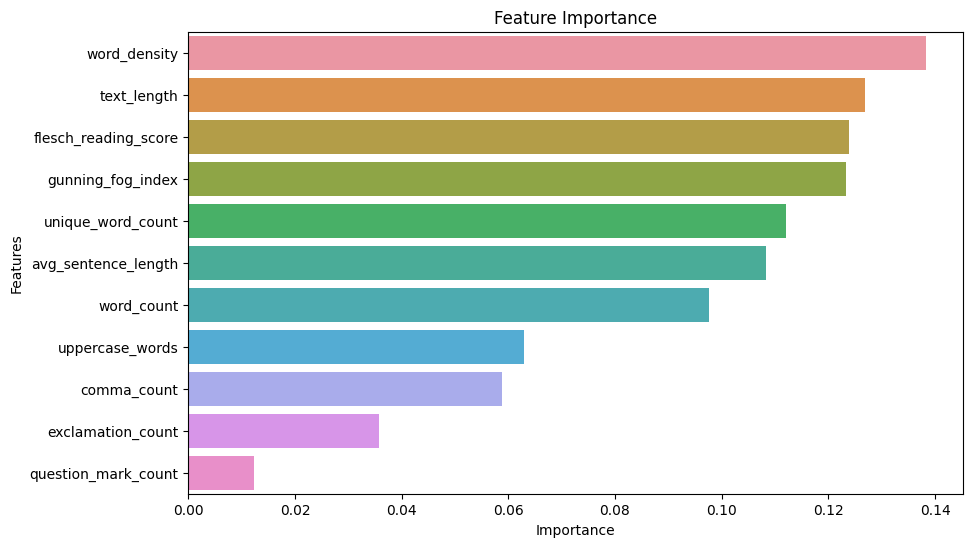

In [24]:
X = df[['text_length', 'word_count', 'unique_word_count', 'word_density', 'uppercase_words', 'comma_count', 'exclamation_count', 'question_mark_count', 'avg_sentence_length', 'flesch_reading_score', 'gunning_fog_index']]
y = df['NPS_category']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

rf_classifier = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred, average='weighted')
recall = recall_score(y_valid, y_pred, average='weighted')
f1 = f1_score(y_valid, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1-score (Weighted):", f1)

# Get feature importance
feature_importance = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Features': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Features', orient="h")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

<div class="alert alert-info" role="alert">
    The features created are not very strong at predicting the target. Upon further research some more stronger features included the noun count and the verb count.
</div>

In [25]:
# calculating the nouns and verbs

def pos_proportions(text, pos_tag):
    sentences = sent_tokenize(text)
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    tagged_sentences = pos_tag_sents(tokenized_sentences)
    
    pos_counts = 0
    total_words = 0
    
    for sentence in tagged_sentences:
        for word, tag in sentence:
            if word.isalpha():
                total_words += 1
                if tag.startswith(pos_tag):
                    pos_counts += 1
    
    return pos_counts / total_words if total_words > 0 else 0

tqdm.pandas(desc="Counting the nouns")
df["noun_proportions"] = df['review_text'].progress_apply(lambda x: pos_proportions(x, "NN"))
tqdm.pandas(desc="Counting the verbs")
df["verb_proportions"] = df['review_text'].progress_apply(lambda x: pos_proportions(x, "VB"))
df[["clean_text", "noun_proportions", "verb_proportions"]]

Counting the verbs: 100%|██████████| 56606/56606 [07:46<00:00, 121.44it/s]


,clean_text,noun_proportions,verb_proportions
0,text rush organise transport effort implicatio...,0.483871,0.193548
1,asia vistara surprise swift immaculate steward...,0.242718,0.165049
3,ever bore carry duty inbound,0.451613,0.064516
4,deserves last block respond mail operator harr...,0.240506,0.253165
5,penalty fail earth would dare season arrogant ...,0.342857,0.200000
...,...,...,...
65737,still due outbreak uncertain get refund client,0.222222,0.111111
65738,h hot still,0.263158,0.131579
65739,first via twitter informative find alex get so...,0.265625,0.156250
65740,faro nd send u lose phone,0.333333,0.177778


Accuracy: 0.8430610514414923
Precision (Weighted): 0.8016488616686931
Recall (Weighted): 0.8430610514414923
F1-score (Weighted): 0.7848803861012239


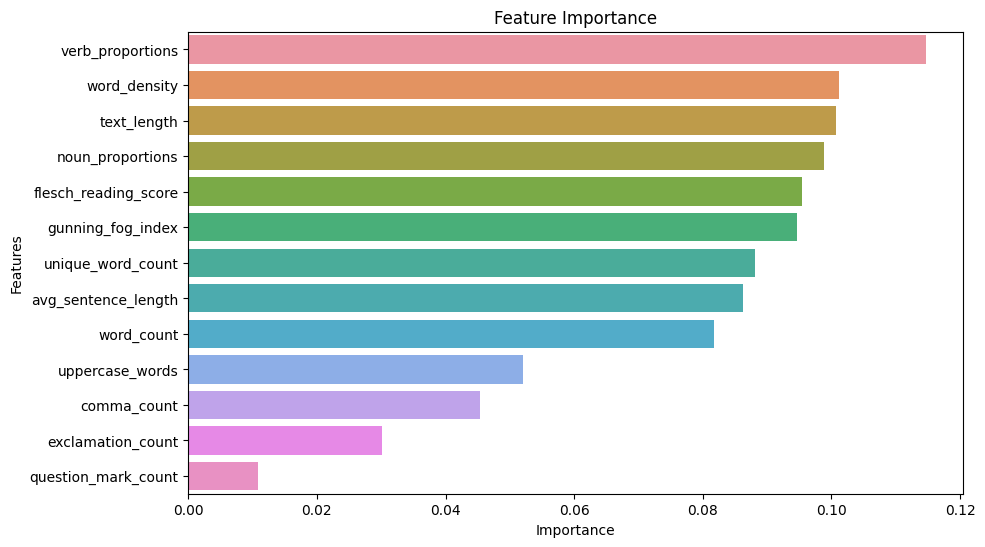

In [26]:
X = X.assign(noun_proportions=df['noun_proportions'], verb_proportions=df['verb_proportions'])
y = df['NPS_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf_classifier = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision (Weighted):", precision)
print("Recall (Weighted):", recall)
print("F1-score (Weighted):", f1)

feature_importance = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Features': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Features', orient="h")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

In [27]:
threshold = 0.06 # threshold for removing features

feature_importance_df = pd.DataFrame({'Features': X.columns, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Identify features with importance below the threshold
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Features']

X_reduced = X.drop(columns=low_importance_features)
X_reduced

,text_length,word_count,unique_word_count,word_density,avg_sentence_length,flesch_reading_score,gunning_fog_index,noun_proportions,verb_proportions
0,194,32,29,5.878788,6.600000,81.90,5.06,0.483871,0.193548
1,608,109,74,5.527273,27.250000,61.19,14.08,0.242718,0.165049
3,204,30,30,6.580645,10.000000,61.33,8.00,0.451613,0.064516
4,464,87,64,5.272727,14.833333,74.39,7.45,0.240506,0.253165
5,240,38,35,6.153846,12.666667,58.58,10.34,0.342857,0.200000
...,...,...,...,...,...,...,...,...,...
65737,188,30,31,6.064516,10.666667,69.79,8.00,0.222222,0.111111
65738,202,39,36,5.050000,8.000000,83.66,7.25,0.263158,0.131579
65739,371,65,48,5.621212,10.833333,66.74,8.28,0.265625,0.156250
65740,240,50,44,4.705882,16.000000,80.62,7.23,0.333333,0.177778


In [28]:
# removing the redudandant columns
columns_to_remove = ['word_count', 'comma_count', 'flesch_reading_score']

# Remove the specified columns
X_reduced = X_reduced.drop(columns=columns_to_remove, errors='ignore')
X_reduced

,text_length,unique_word_count,word_density,avg_sentence_length,gunning_fog_index,noun_proportions,verb_proportions
0,194,29,5.878788,6.600000,5.06,0.483871,0.193548
1,608,74,5.527273,27.250000,14.08,0.242718,0.165049
3,204,30,6.580645,10.000000,8.00,0.451613,0.064516
4,464,64,5.272727,14.833333,7.45,0.240506,0.253165
5,240,35,6.153846,12.666667,10.34,0.342857,0.200000
...,...,...,...,...,...,...,...
65737,188,31,6.064516,10.666667,8.00,0.222222,0.111111
65738,202,36,5.050000,8.000000,7.25,0.263158,0.131579
65739,371,48,5.621212,10.833333,8.28,0.265625,0.156250
65740,240,44,4.705882,16.000000,7.23,0.333333,0.177778


In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_reduced = scaler.fit_transform(X_reduced)
X_reduced

array([[-0.68498528, -0.84373337,  1.05928346, ..., -0.74790872,
         2.48354318,  0.0899737 ],
       [-0.05817722, -0.02380157,  0.19390427, ...,  0.80016744,
        -0.3344894 , -0.46337615],
       [-0.66984498, -0.82551267,  2.78715402, ..., -0.24332514,
         2.10658557, -2.41530253],
       ...,
       [-0.41700212, -0.49753995,  0.4251694 , ..., -0.19526956,
        -0.06681062, -0.63420771],
       [-0.61533994, -0.57042277, -1.82823938, ..., -0.37547798,
         0.72440769, -0.21622673],
       [-0.51844207, -0.60686419,  0.97894322, ...,  0.08963138,
         0.4952766 , -0.62231072]])

In [30]:
X_reduced_train, X_reduced_valid = train_test_split(X_reduced, test_size=0.25, random_state=42)

### Bag of words ❌

- Bag of words was used for its simplicity and ease of use
- Effective for short to medium texts with a mean word count of 121
- Serves as a good baseline
- Experimented with: 
    - Adding meta text features
    - Bigrams

In [31]:
# creating bag of words representation

count_vectorizer = CountVectorizer()
bow_matrix = count_vectorizer.fit_transform(df["clean_text"])

X_train_bow, X_valid_bow, y_train_bow, y_valid_bow = train_test_split(
    bow_matrix, df["NPS_category"], test_size=0.25, random_state=42)

clf_bow = LogisticRegression(class_weight='balanced', max_iter=1500)
clf_bow.fit(X_train_bow, y_train_bow)
y_pred_bow = clf_bow.predict(X_valid_bow)
print("BoW Classification Report:\n", classification_report(y_valid_bow, y_pred_bow))

BoW Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91     11894
           1       0.08      0.19      0.11       338
           2       0.56      0.75      0.64      1920

    accuracy                           0.84     14152
   macro avg       0.53      0.60      0.55     14152
weighted avg       0.88      0.84      0.86     14152



In [32]:
# X_reduced_train, X_reduced_valid

X_train_combined = hstack([X_train_bow, X_reduced_train])
X_valid_combined = hstack([X_valid_bow, X_reduced_valid])

clf_combined = LogisticRegression(class_weight='balanced', max_iter=1500)
clf_combined.fit(X_train_combined, y_train)

y_pred_combined = clf_combined.predict(X_valid_combined)
print(classification_report(y_valid_bow, y_pred_combined))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92     11894
           1       0.08      0.19      0.12       338
           2       0.58      0.74      0.65      1920

    accuracy                           0.84     14152
   macro avg       0.54      0.60      0.56     14152
weighted avg       0.89      0.84      0.86     14152



<div class="alert alert-info" role="alert">
--> Relatively stable performance with a very slight increase in precision (for class 2), recall (for class 0), and f1-score (for all classes). <br>
--> Indicates that combing bag of words with meta features shows no performance boost. <br>
Lets see if ngrams is effective in observing performance gains.
</div>

In [33]:
# creating bag of words representation with unigrams + bigrams
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
bow_matrix = count_vectorizer.fit_transform(df["clean_text"])

X_train_bow, X_valid_bow, y_train_bow, y_valid_bow = train_test_split(
    bow_matrix, df["NPS_category"], test_size=0.25, random_state=42)

clf_bow = LogisticRegression(class_weight='balanced', max_iter=1500)
clf_bow.fit(X_train_bow, y_train_bow)
y_pred_bow = clf_bow.predict(X_valid_bow)
print("BoW Classification Report:\n", classification_report(y_valid_bow, y_pred_bow))

BoW Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     11894
           1       0.12      0.09      0.10       338
           2       0.62      0.75      0.68      1920

    accuracy                           0.88     14152
   macro avg       0.56      0.59      0.57     14152
weighted avg       0.89      0.88      0.88     14152



<div class="alert alert-info" role="alert">
    --> For Class 0, the inclusion of bigrams led to an improvement in both precision (from 0.96 to 0.95) and recall (from 0.87 to 0.93) for Class 0 which suggests that the bigrams were slightly effective in capturing the contextual information for this class <br><br>
    --> For Class 1, there was a slight increase in precision (from 0.08 to 0.12) but a decrease in recall (from 0.19 to 0.09). This indicates that while the model became slightly more precise in its predictions for Class 1 with bigrams, it also became less sensitive to detecting true instances of this class. This could be due to the very large class imbalance and the fact that the class weights are not effective enough at handling it.<br><br>
    --> For Class 2, the addition of bigrams resulted in an increase in both precision (from 0.56 to 0.62) and recall (from 0.75 to 0.75) for Class 2. This improvement suggests that bigrams provided valuable context that enhanced the model's ability to accurately classify instances of Class 2.
<br><br>
We will not try trigrams since the similar performance is to be expected and also because of the long runtime.
</div>

### TFIDF ❌
- TF-IDF improves upon the basic Bag of Words model by not just counting words, but by assigning weights to words based on their importance. Common words across all documents receive lower weights, while unique words in specific documents are emphasized (reduction in noise)
- Can better capture the relevance of terms within specific reviews. This is crucial in understanding the sentiment and specifics of airline service, where certain terms might be particularly indicative of positive or negative experiences.
- Experimented with: 
    - Adding meta text features
    - Bigrams

In [34]:
# creating a TF-IDF text representation

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_text"])

X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(
    tfidf_matrix, df["NPS_category"], test_size=0.25, random_state=42)

clf_tfidf = LogisticRegression(class_weight='balanced', max_iter=2000)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = clf_tfidf.predict(X_valid_tfidf)
print("TF-IDF Classification Report:\n", classification_report(y_valid_tfidf, y_pred_tfidf))

TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91     11894
           1       0.09      0.25      0.13       338
           2       0.58      0.75      0.65      1920

    accuracy                           0.84     14152
   macro avg       0.54      0.62      0.57     14152
weighted avg       0.89      0.84      0.86     14152



<div class="alert alert-info" role="alert">
--> Performance wise is already much higher than the bag of words embeddings, especially for the passives/neutral/class 1 in terms of recall. There is a slight dip in precision (by 0.03 to 0.04) for class 1 and 2
</div>

In [35]:
# X_reduced_train, X_reduced_valid

X_train_combined = hstack([X_train_tfidf, X_reduced_train])
X_valid_combined = hstack([X_valid_tfidf, X_reduced_valid])

clf_combined = LogisticRegression(class_weight='balanced', max_iter=2000)
clf_combined.fit(X_train_combined, y_train_tfidf)

y_pred_combined = clf_combined.predict(X_valid_combined)
print(classification_report(y_valid_tfidf, y_pred_combined))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91     11894
           1       0.09      0.25      0.13       338
           2       0.59      0.75      0.66      1920

    accuracy                           0.84     14152
   macro avg       0.55      0.62      0.57     14152
weighted avg       0.89      0.84      0.86     14152



<div class="alert alert-info" role="alert">
--> No performance gain can be seen in any class when adding the text meta features
</div>

In [36]:
# creating tfidf representation with unigrams + bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_text"])

X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(
    tfidf_matrix, df["NPS_category"], test_size=0.25, random_state=42)


clf_tfidf = LogisticRegression(class_weight='balanced', max_iter=2000)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_tfidf = clf_tfidf.predict(X_valid_tfidf)
print("TF-IDF Classification Report:\n", classification_report(y_valid_tfidf, y_pred_tfidf))

TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94     11894
           1       0.18      0.09      0.12       338
           2       0.65      0.76      0.70      1920

    accuracy                           0.89     14152
   macro avg       0.59      0.60      0.59     14152
weighted avg       0.89      0.89      0.89     14152



<div class="alert alert-info" role="alert">
--> After adding in bigrams the model is able to predict class 2 better than before, however there is a significant drop in recall for class 1 which is of concern. <br>
--> Since all the classes are equally important, tfidf on its own is not very suitable. A new technique has been research and found called delta tfidf which will be explore below. 
</div>

### Delta Tfidf ✅

- Enhanced Feature Discrimination: Delta TF-IDF amplifies the features (words) that are more discriminative for each class by adjusting their TF-IDF values based on their deviation from a mean IDF calculated across all classes leading to better separation of classes.
- However, one thing to note is that delta TF-IDF has negative values which means it cannot be used with naive bayes models. An alternative is to use Gaussian Bayes, however it doesnt support class weights, which makes it unsuitable to use.

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(df['clean_text'], df['NPS_category'], test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

class_idfs = []
unique_classes = np.unique(y_train)
for class_idx in unique_classes:
    class_mask = (y_train == class_idx)
    class_docs = X_train[class_mask]
    class_vectorizer = TfidfVectorizer(vocabulary=tfidf_vectorizer.vocabulary_)
    class_tfidf = class_vectorizer.fit_transform(class_docs)
    class_idf = class_vectorizer.idf_
    class_idfs.append(class_idf)

mean_idf = np.mean(class_idfs, axis=0)

delta_idfs = [class_idf - mean_idf for class_idf in class_idfs]

class_to_index = {label: index for index, label in enumerate(unique_classes)}

X_train_delta_tfidf = []
for i, doc in enumerate(X_train_tfidf):
    class_idx = class_to_index[y_train.iloc[i]]
    delta_idf = delta_idfs[class_idx]
    X_train_delta_tfidf.append(doc.multiply(delta_idf))

X_train_delta_tfidf = vstack(X_train_delta_tfidf)

X_valid_tfidf = tfidf_vectorizer.transform(X_valid)
X_valid_delta_tfidf = []
for i, doc in enumerate(X_valid_tfidf):
    class_idx = class_to_index[y_valid.iloc[i]]
    delta_idf = delta_idfs[class_idx]
    X_valid_delta_tfidf.append(doc.multiply(delta_idf))

X_valid_delta_tfidf = vstack(X_valid_delta_tfidf)

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train_delta_tfidf, y_train)

y_pred = clf.predict(X_valid_delta_tfidf)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     11894
           1       0.94      0.76      0.84       338
           2       0.84      1.00      0.92      1920

    accuracy                           0.97     14152
   macro avg       0.93      0.91      0.91     14152
weighted avg       0.98      0.97      0.97     14152



<div class="alert alert-info" role="alert">
--> A much signficant performance upgrade can be seen across all the classes. Since adding meta features and bigrams didnt make much of a difference for tfidf, it is very likely that it will not make much difference for delta tfidf as well.
</div>

## Data Balancing Techniques
Dataset is highly imbalanced which means that the predictions will be highly biased towards the majority class. To fix this it is important to balance the dataset through: 

- using class weights
- using SMOTE
- using adasyn

*note: random oversampling was not used since it works by duplicating the samples in the minority class, even if it has better performance, it is most likely overfitting.*

### Delta Tfidf + class weights (Balancing Technique) ✅

In [38]:
clf = LogisticRegression(class_weight='balanced')

clf.fit(X_train_delta_tfidf, y_train)
y_pred = clf.predict(X_valid_delta_tfidf)

print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     11894
           1       0.94      0.76      0.84       338
           2       0.84      1.00      0.92      1920

    accuracy                           0.97     14152
   macro avg       0.93      0.91      0.91     14152
weighted avg       0.98      0.97      0.97     14152



### Delta Tfidf + SMOTE (Balancing Technique) ❌
- should not be applied on the test data to preserve the original distribution.

In [39]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_delta_tfidf, y_train)

clf_smote = LogisticRegression()
clf_smote.fit(X_train_smote, y_train_smote)
y_pred = clf_smote.predict(X_valid_delta_tfidf)

print("Classification Report after SMOTE:\n", classification_report(y_valid, y_pred))

Classification Report after SMOTE:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     11894
           1       0.54      0.93      0.68       338
           2       0.88      0.99      0.93      1920

    accuracy                           0.96     14152
   macro avg       0.81      0.96      0.87     14152
weighted avg       0.97      0.96      0.97     14152



<div class="alert alert-info" role="alert">
--> A low precision (high false positives) is seen for class 1, this shows that SMOTE is not the best technique to apply.
</div>
</div>

### Delta Tfidf + Adasyn (Balancing Technique) ❌
- should not be applied on the test data to preserve the original distribution.

In [40]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_delta_tfidf, y_train)

clf_adasyn = LogisticRegression()
clf_adasyn.fit(X_train_adasyn, y_train_adasyn)
y_pred = clf_adasyn.predict(X_valid_delta_tfidf)

print("Classification Report after ADASYN:\n", classification_report(y_valid, y_pred))

Classification Report after ADASYN:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98     11894
           1       0.60      0.91      0.72       338
           2       0.84      1.00      0.91      1920

    accuracy                           0.96     14152
   macro avg       0.81      0.95      0.87     14152
weighted avg       0.97      0.96      0.96     14152



<div class="alert alert-info" role="alert">
--> A low precision (high false positives) is seen for class 1, this shows that ADASYN is not the best technique to apply. Class weighting will be the selected technique. This means that for modelling it is important to utilise models that support adding weights for the classes.
</div>
</div>

## Modelling

Some considerations when building models: 

- The SVM classifier can be built using LinearSVC and Stochastic gradient descent with hinge loss. LinearSVC uses the full data to solve the optimization problem which makes it suitable on small datasets however, on larger and more sparse data, SGD (with hinge loss) is more suitable as it handles data in batches assuming data points are independent and identically distributed.

- Boosting algorithms comparison
    - for Adaboost, 2 different stump learners was used which was decision tree (most commonly used) and logistic regression (better baseline performance than decision tree).
    - LightGBM, Catboost and XGBoost is used due to its fast performance and large number of tunable parameters.
    
<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*0xWny_DiMZxN3Ajpg6G5tg.png" style="width: 800px; height: 400px;">
</div>

In [41]:
models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "SVM (SGD)": SGDClassifier(loss='hinge', class_weight='balanced', max_iter=1000, tol=1e-3),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(enable_categorical=True, eval_metric='mlogloss'),
    "AdaBoost+DT": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100),
    "AdaBoost+LR": AdaBoostClassifier(base_estimator=LogisticRegression(multi_class='multinomial',class_weight='balanced',max_iter=1000),n_estimators=100),
    "Catboost": CatBoostClassifier(iterations=500,learning_rate=0.1,depth=6,l2_leaf_reg=3,cat_features=[], auto_class_weights='Balanced',verbose=200, task_type='GPU',devices='0:1'),
    "LightGBM": LGBMClassifier(boosting_type='gbdt', objective='multiclass', class_weight='balanced', learning_rate=0.09, max_depth=-1, random_state=42, n_estimators=100, device='gpu', gpu_platform_id=0, gpu_device_id=0)
}

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    if name == "XGBoost": 
        sample_weights_data = compute_sample_weight("balanced", y_train)
        model.fit(X_train, y_train, sample_weight=sample_weights_data)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"CLASSIFICATION REPORT FOR {name.upper()}")
    print(classification_report(y_test, y_pred))
    return {"Model": name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

In [42]:
results = pd.DataFrame()

for name, model in tqdm(models.items(), desc="Evaluating Models"):
    results_row = evaluate_model(name, model, X_train_delta_tfidf, y_train, X_valid_delta_tfidf, y_valid)
    results = results._append(results_row, ignore_index=True)
    
results

Evaluating Models:  11%|█         | 1/9 [00:04<00:36,  4.62s/it]

CLASSIFICATION REPORT FOR LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     11894
           1       0.94      0.76      0.84       338
           2       0.84      1.00      0.92      1920

    accuracy                           0.97     14152
   macro avg       0.93      0.91      0.91     14152
weighted avg       0.98      0.97      0.97     14152



Evaluating Models:  22%|██▏       | 2/9 [00:11<00:42,  6.01s/it]

CLASSIFICATION REPORT FOR DECISION TREE
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11894
           1       0.34      0.77      0.47       338
           2       0.98      0.92      0.95      1920

    accuracy                           0.96     14152
   macro avg       0.77      0.88      0.80     14152
weighted avg       0.98      0.96      0.96     14152



Evaluating Models:  33%|███▎      | 3/9 [00:12<00:20,  3.46s/it]

CLASSIFICATION REPORT FOR SVM (SGD)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11894
           1       1.00      0.54      0.70       338
           2       0.98      0.95      0.97      1920

    accuracy                           0.98     14152
   macro avg       0.99      0.83      0.88     14152
weighted avg       0.98      0.98      0.98     14152



Evaluating Models:  44%|████▍     | 4/9 [00:37<01:00, 12.09s/it]

CLASSIFICATION REPORT FOR RANDOM FOREST
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11894
           1       0.91      0.57      0.70       338
           2       0.98      0.94      0.96      1920

    accuracy                           0.98     14152
   macro avg       0.96      0.84      0.89     14152
weighted avg       0.98      0.98      0.98     14152



Evaluating Models:  56%|█████▌    | 5/9 [01:17<01:28, 22.20s/it]

CLASSIFICATION REPORT FOR XGBOOST
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     11894
           1       0.63      0.79      0.70       338
           2       0.71      1.00      0.83      1920

    accuracy                           0.93     14152
   macro avg       0.78      0.90      0.83     14152
weighted avg       0.95      0.93      0.94     14152



Evaluating Models:  67%|██████▋   | 6/9 [01:32<00:59, 19.84s/it]

CLASSIFICATION REPORT FOR ADABOOST+DT
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11894
           1       0.89      0.58      0.70       338
           2       0.99      0.74      0.85      1920

    accuracy                           0.95     14152
   macro avg       0.94      0.77      0.84     14152
weighted avg       0.95      0.95      0.95     14152



Evaluating Models:  78%|███████▊  | 7/9 [01:57<00:42, 21.45s/it]

CLASSIFICATION REPORT FOR ADABOOST+LR
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     11894
           1       0.24      0.92      0.39       338
           2       0.80      0.99      0.89      1920

    accuracy                           0.90     14152
   macro avg       0.68      0.93      0.74     14152
weighted avg       0.96      0.90      0.92     14152

0:	learn: 1.0357059	total: 517ms	remaining: 4m 17s
200:	learn: 0.3256890	total: 26s	remaining: 38.6s
400:	learn: 0.2541059	total: 51.4s	remaining: 12.7s
499:	learn: 0.2263709	total: 1m 2s	remaining: 0us


Evaluating Models:  89%|████████▉ | 8/9 [03:08<00:37, 37.37s/it]

CLASSIFICATION REPORT FOR CATBOOST
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     11894
           1       0.68      0.75      0.71       338
           2       0.60      1.00      0.75      1920

    accuracy                           0.90     14152
   macro avg       0.76      0.88      0.80     14152
weighted avg       0.94      0.90      0.91     14152

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 192306
[LightGBM] [Info] Number of data points in the train set: 42454, number of used features: 4410
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


Evaluating Models: 100%|██████████| 9/9 [03:30<00:00, 23.35s/it]

CLASSIFICATION REPORT FOR LIGHTGBM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     11894
           1       0.73      0.80      0.76       338
           2       0.76      1.00      0.86      1920

    accuracy                           0.95     14152
   macro avg       0.83      0.92      0.87     14152
weighted avg       0.96      0.95      0.95     14152



,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.972583,0.976182,0.972583,0.973122
1,Decision Tree,0.955766,0.975655,0.955766,0.963423
2,SVM (SGD),0.982335,0.982521,0.982335,0.980655
3,Random Forest,0.980568,0.979964,0.980568,0.979218
4,XGBoost,0.931529,0.950121,0.931529,0.936049
5,AdaBoost+DT,0.953010,0.953768,0.953010,0.949724
6,AdaBoost+LR,0.898954,0.955261,0.898954,0.917976
7,Catboost,0.901215,0.937190,0.901215,0.909922
8,LightGBM,0.948912,0.959795,0.948912,0.951492


<div class="alert alert-info" role="alert">
--> SGD (SVM) and Random Forest exhibit the highest F1-Score, making them top performers for precise classification. <br>
--> Logistic Regression is close behind, with strong metrics, suggesting it's a reliable choice.<br>
--> Decision Tree shows lower performance, which might indicate it's less suited for this task.<br>
--> XGBoost underperforms in this comparison, hinting at the need for more optimization.<br>
</div>

### Dimensionality reduction techniques

#### SVD

SVD finished
logreg init
logreg fit
logreg predict
Accuracy: 0.8529536461277558
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     11894
           1       0.13      0.95      0.24       338
           2       0.99      0.75      0.85      1920

    accuracy                           0.85     14152
   macro avg       0.71      0.85      0.67     14152
weighted avg       0.98      0.85      0.90     14152



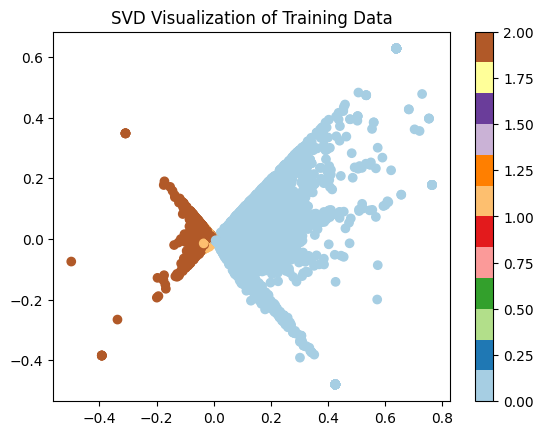

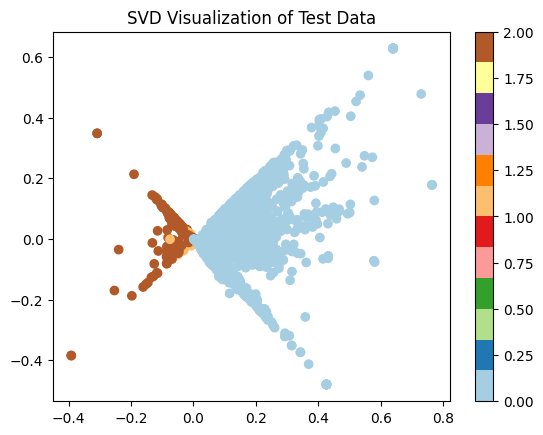

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Step 1: Apply Truncated SVD for feature reduction on CPU
n_components = 50  # Adjust the number of components
n_iter = 10  # Adjust the number of iterations
random_state = 42  # Set a fixed random state for reproducibility
algorithm = 'randomized'  # Experiment with different algorithms

svd = TruncatedSVD(
    n_components=n_components,
    n_iter=n_iter,
    random_state=random_state,
    algorithm=algorithm
)

# Fit and transform on training data
X_train_svd = svd.fit_transform(X_train_delta_tfidf.toarray())

# Transform on test data
X_valid_svd = svd.transform(X_valid_delta_tfidf.toarray())
print("SVD finished")

# Step 2: Logistic Regression with class weights for evaluation
logistic_regression = LogisticRegression(class_weight='balanced')
print("logreg init")

# Fit the model
logistic_regression.fit(X_train_svd, y_train)
print("logreg fit")

# Predictions
y_pred = logistic_regression.predict(X_valid_svd)
print("logreg predict")

# Step 3: Evaluation
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

# Step 4: Visualize SVD results
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.colorbar()
plt.title("SVD Visualization of Training Data")
plt.show()

plt.scatter(X_valid_svd[:, 0], X_valid_svd[:, 1], c=y_test, cmap=plt.cm.Paired)
plt.colorbar()
plt.title("SVD Visualization of Test Data")
plt.show()

## Evaluation

In [45]:
test_df = pd.read_csv("/kaggle/input/dataprocessing/testing_data.csv", index_col=0)
# test_df = pd.read_csv("./DataScraping_and_processing/testing_data.csv", index_col=0)
test_df.head()

,overall_rating,review_date,review_text,airline_name
48188,Rated 1 out of 5 stars,"Monday, March 21, 2022 at 03:17:13 AM",I wrote to Pegasus about the frustrating issue...,pegasus airlines
41101,Rated 1 out of 5 stars,"Saturday, January 15, 2022 at 08:27:27 PM",DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair
75409,Rated 5 out of 5 stars,"Monday, September 11, 2023 at 09:13:10 PM",Useful,volotea
54218,Rated 1 out of 5 stars,"Thursday, June 29, 2023 at 06:48:40 AM",Ryanair cancelled my flight less than 24hrs be...,ryanair
15113,Rated 1 out of 5 stars,"Thursday, February 24, 2022 at 03:28:20 PM",It’s clear that BA are not even interested in ...,british airways


In [46]:
test_df.shape

(16436, 4)

In [47]:
test_df["review_text"].dropna()

48188    I wrote to Pegasus about the frustrating issue...
41101    DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...
75409                                               Useful
54218    Ryanair cancelled my flight less than 24hrs be...
15113    It’s clear that BA are not even interested in ...
                               ...                        
61676    Worse than Ryanair. Enforces baggage weight re...
75438                                               Useful
79400    Just What You Expect From. A Budget Airline. N...
71018    Baggage handling is a MESS! They keep losing l...
37954    Never EVER again\n\nI wouldn't trust this comp...
Name: review_text, Length: 16436, dtype: object

In [53]:
slang_dict = {}
word_freq = Counter()

with open('/kaggle/input/dataprocessing/slang.txt', 'r') as file:
    slang_dict = {key.lower(): value.lower() for line in file if '=' in line for key, value in [line.strip().split('=', 1)]}

# with open('DataScraping_and_processing/slang.txt', 'r') as file:
#     slang_dict = {key.lower(): value.lower() for line in file if '=' in line for key, value in [line.strip().split('=', 1)]}
    
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review_text'])

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

tfidf_sum = np.sum(tfidf_matrix, axis=0)
tfidf_scores = np.squeeze(np.asarray(tfidf_sum))

sorted_indices = np.argsort(tfidf_scores)

freq_word_threshold = np.quantile(tfidf_scores, 0.97) 
rare_word_threshold = np.quantile(tfidf_scores, 0.03)

FREQWORDS = set(feature_names[tfidf_scores > freq_word_threshold])
RAREWORDS = set(feature_names[tfidf_scores < rare_word_threshold])

print("Frequent Words:", list(FREQWORDS)[:5])
print("\nRare Words:", list(RAREWORDS)[:5])

def detect_language(text):
    lang, _ = langid.classify(text)
    return lang

tqdm.pandas(desc="Detecting languages")
test_df['language_info'] = test_df['review_text'].progress_apply(detect_language)
test_df.loc[test_df["language_info"] != "en"]

def remove_rows(dataframe):
    print("rows removed")
    return (dataframe.dropna()
            .drop_duplicates()
            .query("language_info == 'en'")
            .loc[dataframe['review_text'].str.split().str.len() > 2])

data_cleaning_pipeline = Pipeline([
    ('remove_rows', FunctionTransformer(remove_rows)),
])

# text cleaning functions

def remove_excess_space(text):
    text = " ".join(text.split()) 
    text = re.sub(r'\s([?.!"](?:\s|$))', r'\1', text)
    return text

def remove_url(text):
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    return re.sub(regex, '', text)

def html_tag_remover(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    return text

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def normalize_exaggerated_text(text):
    normalized_text = re.sub(r'(.)\1{2,}', r'\1', text)
    return normalized_text

def replace_slang(text):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b')
    return pattern.sub(lambda x: slang_dict[x.group().lower()], text)

def convert_emoticons_and_emojis(text, emoticons_emo=EMOTICONS_EMO, emoji_unicode=EMOJI_UNICODE):
    emoticon_patterns = {re.escape(k): "_".join(v.replace(",", "").split()) for k, v in emoticons_emo.items()}
    emoji_patterns = {re.escape(v): k.strip(":") for k, v in emoji_unicode.items()}
    combined_patterns = {**emoticon_patterns, **emoji_patterns}

    pattern = re.compile('|'.join(combined_patterns.keys()))

    def replace(match):
        return combined_patterns[re.escape(match.group(0))]

    return pattern.sub(replace, text)

def remove_username(text): 
    return re.sub('@[^\s]+','',text)

symsp = SymSpell()
symsp.load_dictionary('/kaggle/input/dataprocessing/my_frequency_dictionary.txt', term_index=0, count_index=1, separator=' ')

def correct_spelling(text):
    corrected = symsp.lookup_compound(text, max_edit_distance=2)
    return corrected[0].term if corrected else text

def remove_money(text):
    pattern = r'(?:\$|\£|\€|\₹)?\d+(?:\.\d{1,2})?'
    return re.sub(pattern, '', text)

def fix_negation(sentence):
    for i in range(1, len(sentence)):
        if sentence[i-1] in ['not', "n't"]:
            synsets = wordnet.synsets(sentence[i])
            if synsets:
                w1 = synsets[0]
                antonyms = [l.antonyms()[0].name() for l in w1.lemmas() if l.antonyms()]
                if antonyms:
                    max_dissimilarity = 0
                    for ant in antonyms:
                        ant_synsets = wordnet.synsets(ant)
                        if ant_synsets:
                            similarity = w1.wup_similarity(ant_synsets[0])
                            # Check if similarity is None and handle it
                            if similarity is None:
                                continue  # Skip this comparison
                            dissimilarity = 1 - similarity
                            if dissimilarity > max_dissimilarity:
                                max_dissimilarity = dissimilarity
                                sentence[i] = ant
                    sentence[i-1] = ''

    sentence = [word for word in sentence if word]
    return ' '.join(sentence)  # Return a string instead of a list


STOPWORDS = stopwords.words("english")
STOPWORDS += ['u', 'back', 'one']

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])


tqdm.pandas()

text_preprocessing_pipeline = Pipeline(steps=[
    ('lowercase', FunctionTransformer(lambda x: x.progress_apply(str.lower))),
    ('remove excess whitespace', FunctionTransformer(lambda x: x.progress_apply(remove_excess_space))),
    ('remove_url', FunctionTransformer(lambda x: x.progress_apply(remove_url))),
    ('html_tag_remover', FunctionTransformer(lambda x: x.progress_apply(html_tag_remover))),
    ('money_remover', FunctionTransformer(lambda x: x.progress_apply(remove_money))),
    ('convert_emoticons_and_emojii', FunctionTransformer(lambda x: x.progress_apply(convert_emoticons_and_emojis))),
    ('remove_username', FunctionTransformer(lambda x: x.progress_apply(remove_username))),
    ('replace_slang', FunctionTransformer(lambda x: x.progress_apply(replace_slang))),
    ('correct_spelling', FunctionTransformer(lambda x: x.progress_apply(correct_spelling))),
    ('expand_contractions', FunctionTransformer(lambda x: x.progress_apply(lambda text: contractions.fix(text)))),
    ('fix_negation', FunctionTransformer(lambda x: x.progress_apply(lambda text: "".join(fix_negation(word_tokenize(text)))))),
    ('remove_punctuation', FunctionTransformer(lambda x: x.progress_apply(remove_punctuation))),
    ('normalize_exaggerated_text', FunctionTransformer(lambda x: x.progress_apply(normalize_exaggerated_text))),
    ('remove_stopwords', FunctionTransformer(lambda x: x.progress_apply(remove_stopwords))),
    ('remove_freqwords', FunctionTransformer(lambda x: x.progress_apply(remove_freqwords))),
    ('remove_rarewords', FunctionTransformer(lambda x: x.progress_apply(remove_rarewords))),
    ('lemmatize_words', FunctionTransformer(lambda x: x.progress_apply(lemmatize_words)))
])

Frequent Words: ['reference', 'moved', 'original', 'priority', 'leg']

Rare Words: ['gopro', '937', 'motives', 'malé', 'senza']


Detecting languages: 100%|██████████| 16436/16436 [01:01<00:00, 266.45it/s]


In [57]:
test_df = data_cleaning_pipeline.fit_transform(test_df)
test_df['clean_text'] = text_preprocessing_pipeline.fit_transform(test_df['review_text'])
test_df.head()

rows removed


100%|██████████| 15361/15361 [00:31<00:00, 490.14it/s]


,overall_rating,review_date,review_text,airline_name,NPS_category,language_info,clean_text
48188,Rated 1 out of 5 stars,"Monday, March 21, 2022 at 03:17:13 AM",I wrote to Pegasus about the frustrating issue...,pegasus airlines,0,en,write pegasus frustrate even
41101,Rated 1 out of 5 stars,"Saturday, January 15, 2022 at 08:27:27 PM",DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,0,en,repeat phone take restriction could normal cir...
54218,Rated 1 out of 5 stars,"Thursday, June 29, 2023 at 06:48:40 AM",Ryanair cancelled my flight less than 24hrs be...,ryanair,0,en,less departs answer keep bot fight get full ev...
15113,Rated 1 out of 5 stars,"Thursday, February 24, 2022 at 03:28:20 PM",It’s clear that BA are not even interested in ...,british airways,0,en,even interested rant effort part needless airp...
16266,Rated 1 out of 5 stars,"Thursday, August 5, 2021 at 04:58:50 PM",Waited for 2 hours for customer service to res...,british airways,0,en,call urgent call respond


In [62]:
def classify_nps(rating_text):
    rating_text = rating_text.strip()
    if "Rated" in rating_text:
        rating = int(rating_text.split(' ')[1])
        return "Detractor" if rating <= 2 else ("Neutral" if rating == 3 else "Promoter")
    else:
        rating = int(float(rating_text))
        return "Detractor" if rating <= 6 else ("Neutral" if rating <= 8 else "Promoter")
        
        
        
test_df["NPS_category"] = test_df["overall_rating"].apply(classify_nps)
test_df["NPS_category"] = test_df["NPS_category"].map({"Detractor": 0, "Neutral": 1, "Promoter": 2})
test_df.head()

,overall_rating,review_date,review_text,airline_name,NPS_category,language_info,clean_text
48188,Rated 1 out of 5 stars,"Monday, March 21, 2022 at 03:17:13 AM",I wrote to Pegasus about the frustrating issue...,pegasus airlines,0,en,write pegasus frustrate even
41101,Rated 1 out of 5 stars,"Saturday, January 15, 2022 at 08:27:27 PM",DON'T I REPEAT DON'T TRAVEL WITH THIS SO CALLE...,icelandair,0,en,repeat phone take restriction could normal cir...
54218,Rated 1 out of 5 stars,"Thursday, June 29, 2023 at 06:48:40 AM",Ryanair cancelled my flight less than 24hrs be...,ryanair,0,en,less departs answer keep bot fight get full ev...
15113,Rated 1 out of 5 stars,"Thursday, February 24, 2022 at 03:28:20 PM",It’s clear that BA are not even interested in ...,british airways,0,en,even interested rant effort part needless airp...
16266,Rated 1 out of 5 stars,"Thursday, August 5, 2021 at 04:58:50 PM",Waited for 2 hours for customer service to res...,british airways,0,en,call urgent call respond


In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(df['clean_text'], df['NPS_category'], test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer(lowercase=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

class_idfs = []
unique_classes = np.unique(y_train)
for class_idx in unique_classes:
    class_mask = (y_train == class_idx)
    class_docs = X_train[class_mask]
    class_vectorizer = TfidfVectorizer(vocabulary=tfidf_vectorizer.vocabulary_, lowercase=True)
    class_tfidf = class_vectorizer.fit_transform(class_docs)
    class_idf = class_vectorizer.idf_
    class_idfs.append(class_idf)

mean_idf = np.mean(class_idfs, axis=0)

delta_idfs = [class_idf - mean_idf for class_idf in class_idfs]

class_to_index = {label: index for index, label in enumerate(unique_classes)}
X_train_delta_tfidf = []
for i, doc in enumerate(X_train_tfidf):
    class_idx = class_to_index[y_train.iloc[i]]
    delta_idf = delta_idfs[class_idx]
    X_train_delta_tfidf.append(doc.multiply(delta_idf))

X_train_delta_tfidf = vstack(X_train_delta_tfidf)

clf = SGDClassifier(loss='hinge', class_weight='balanced', max_iter=1000, tol=1e-3)
clf.fit(X_train_delta_tfidf, y_train)

SGDClassifier(class_weight='balanced')

In [74]:
X_test_tfidf = tfidf_vectorizer.transform(test_df['review_text'])
y_test = test_df['NPS_category']


X_test_delta_tfidf = []
for i, doc in enumerate(X_test_tfidf):
    class_idx = class_to_index[y_test.iloc[i]]
    delta_idf = delta_idfs[class_idx]
    X_test_delta_tfidf.append(doc.multiply(delta_idf))

X_test_delta_tfidf = vstack(X_test_delta_tfidf)


y_pred = clf.predict(X_test_delta_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12888
           1       1.00      0.68      0.81       361
           2       0.98      0.97      0.97      2112

    accuracy                           0.99     15361
   macro avg       0.99      0.88      0.93     15361
weighted avg       0.99      0.99      0.99     15361



In [75]:
# hyperparameter tuning


sgd_clf = SGDClassifier(loss='hinge', class_weight='balanced', max_iter=1000, tol=1e-3)

param_dist = {
    'alpha': loguniform(1e-7, 1e-2),  # Broaden the range a bit to include smaller and larger values
    'learning_rate': ['optimal', 'invscaling', 'adaptive'],  # This is fine as is, covering all the options
    'eta0': loguniform(1e-6, 1e-1),  # Adjust the range for initial learning rate to be broader
    'penalty': ['l2', 'l1', 'elasticnet'],  # Including all relevant penalties
    'l1_ratio': uniform(0, 1),
    'power_t': uniform(0.1, 0.9)  # For 'invscaling' learning rate, exploring a range for power_t could be beneficial
}

random_search = RandomizedSearchCV(sgd_clf, param_distributions=param_dist, n_iter=50, 
                                   scoring='f1_weighted', n_jobs=-1, cv=5, random_state=42)


random_search.fit(X_train_delta_tfidf, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)

y_pred = best_model.predict(X_test_delta_tfidf) 
print(classification_report(y_test, y_pred))

Best Parameters: {'alpha': 7.459343285726551e-06, 'eta0': 0.05669849511478854, 'l1_ratio': 0.7319939418114051, 'learning_rate': 'optimal', 'penalty': 'l2', 'power_t': 0.24041677639819287}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12888
           1       1.00      0.81      0.90       361
           2       0.96      1.00      0.98      2112

    accuracy                           0.99     15361
   macro avg       0.99      0.94      0.96     15361
weighted avg       0.99      0.99      0.99     15361



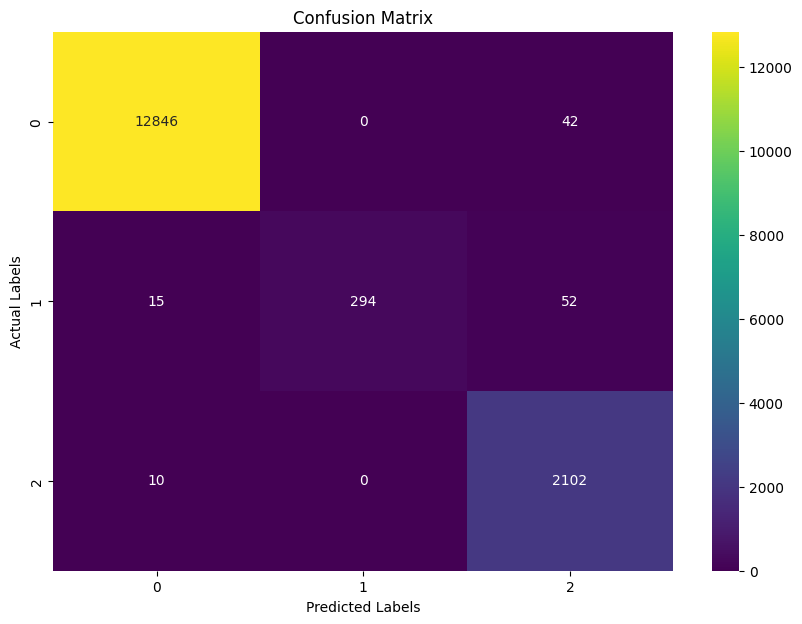

In [76]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

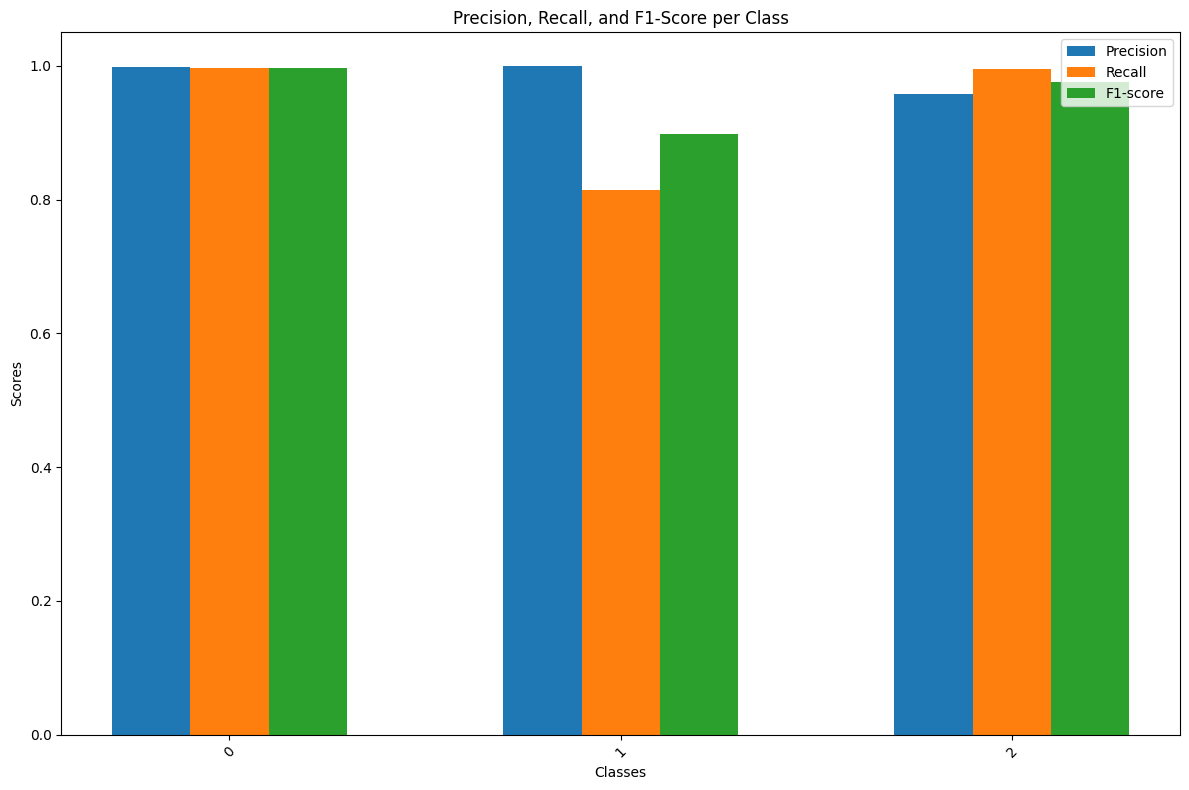

In [77]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
index = np.arange(len(unique_classes))
bar_width = 0.2

p_bar = ax.bar(index, precision, bar_width, label='Precision')
r_bar = ax.bar(index + bar_width, recall, bar_width, label='Recall')
f1_bar = ax.bar(index + 2 * bar_width, f1, bar_width, label='F1-score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score per Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(unique_classes, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [78]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = clf.decision_function(X_test_delta_tfidf)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Assuming your classes are numbered from 0 to n-1
unique_classes = np.arange(n_classes)

In [87]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Set the default renderer to 'iframe' for Jupyter Notebooks or 'notebook' if using JupyterLab
pio.renderers.default = 'iframe'  # or 'notebook' for JupyterLab

# Initialize the plotly figure with a title and a single subplot for the ROC curves
fig = make_subplots(rows=1, cols=1, subplot_titles=['Multiclass ROC Curve'])

# Define a list of colors for the ROC curves
color_palette = [
    '#d62728',  # Muted blue
    '#ff7f0e',  # Safety orange
    '#2ca02c',  # Cooked asparagus green
    '#d62728',  # Brick red
    '#9467bd',  # Muted purple
    '#8c564b',  # Chestnut brown
    '#e377c2',  # Raspberry yogurt pink
    '#7f7f7f',  # Middle gray
    '#bcbd22',  # Curry yellow-green
    '#17becf'   # Blue-teal
]

for i, color in enumerate(color_palette[:len(unique_classes)]):
    fig.add_trace(go.Scatter(x=fpr[i], y=tpr[i], mode='lines',
                             name=f'Class {unique_classes[i]} (AUC = {roc_auc[i]:.2f})',
                             line=dict(color=color, width=2)))

fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance',
                         line=dict(color='gray', width=1.5, dash='dot')))

fig.update_layout(
    title='Multiclass ROC Curve',
    title_x=0.5,
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    legend_title='Class AUC',
    legend=dict(y=0.5, traceorder='reversed', font_size=12),
    margin=dict(l=40, r=40, t=85, b=40),
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(size=12, color='black')
)

fig.update_xaxes(range=[0, 1], showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(range=[0, 1.05], showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

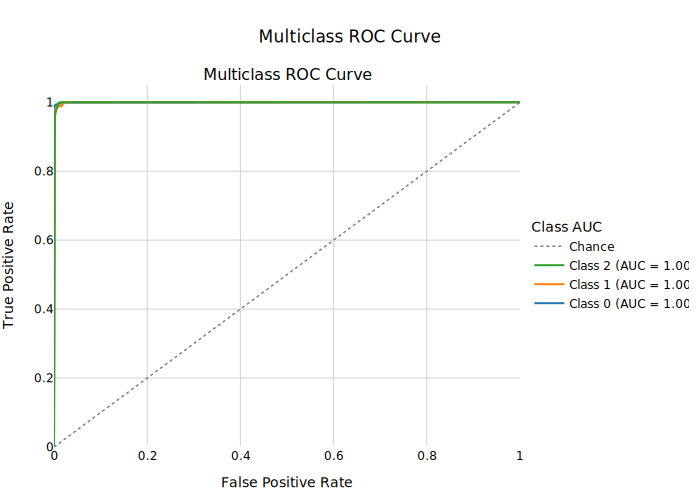

In [80]:
fig.show("svg")

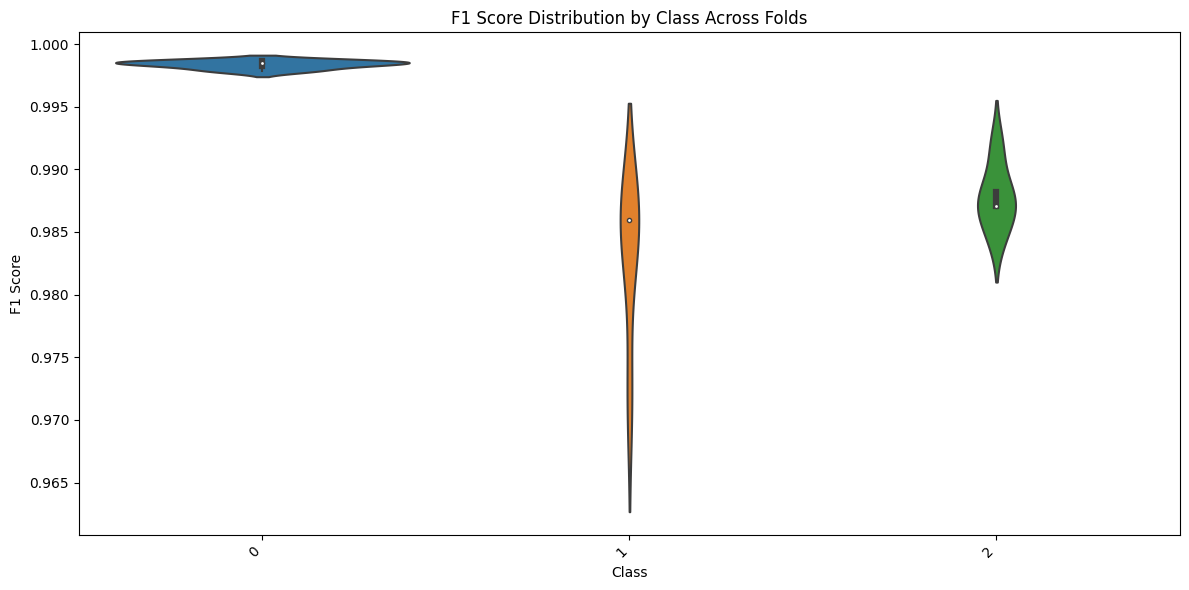

In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

X_csr = csr_matrix(X_test_delta_tfidf)

# Initialize StratifiedKFold
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Collect F1 scores for each fold and class
f1_scores = []

for train_idx, test_idx in cv.split(X_csr, y_test):
    X_train_fold, X_test_fold = X_csr[train_idx], X_csr[test_idx]
    y_train_fold, y_test_fold = y_test.iloc[train_idx], y_test.iloc[test_idx]

    # Fit and predict
    model = clone(best_model)
    model.fit(X_train_fold, y_train_fold)
    y_pred_fold = model.predict(X_test_fold)

    # Compute F1-scores for each class and append to list
    f1_scores.append(f1_score(y_test_fold, y_pred_fold, average=None))

# Convert F1 scores to a DataFrame
f1_df = pd.DataFrame(f1_scores, columns=np.unique(y_test))

# Melt the DataFrame for seaborn compatibility
f1_melted = f1_df.melt(var_name='Class', value_name='F1 Score')

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Class', y='F1 Score', data=f1_melted)
plt.title('F1 Score Distribution by Class Across Folds')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- class 0 (detractors) shows very robust perfromance with a high f1 score and it frequently shows the high f1 score which is a good sign. 
- class 1 (passives/neutrals) shows more variability in performance with the lowest performance being 96.5% which is still not too bad. This is due to the fact that there are very few samples in this class. 
- class 2 (promoters) shows good performance as well, having lesser variability than class 1 but not as high of performance as class 0. This is stil fine since it is more important to focus on the detractors rather than the promoters as negative word of mouth is far worse and long lasting. 

In [81]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa}")

matthews_corr = matthews_corrcoef(y_test, y_pred)
print(f"Matthew's Correlation Coefficient: {matthews_corr}")

Cohen's Kappa: 0.9720216582323901
Matthew's Correlation Coefficient: 0.972110106098203


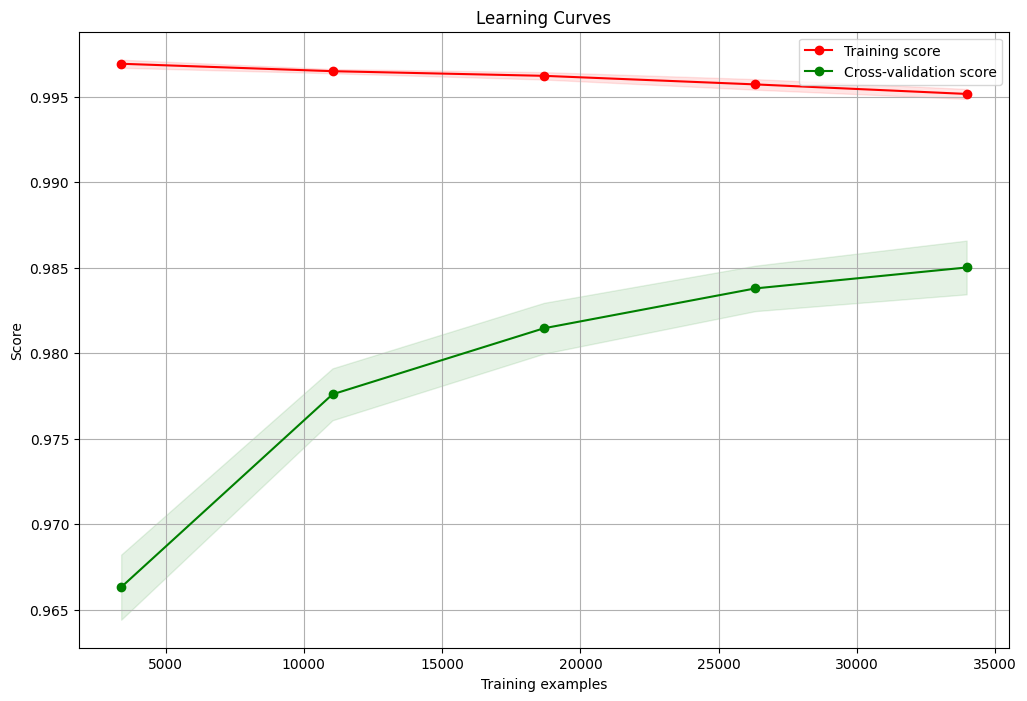

In [82]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(clf, X_train_delta_tfidf, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)

# Calculate mean and std
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curves")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()